# [GD-6] 모든 장르 간 편향성 측정해 보기

# Step 0. 라이브러리 불러오기
---

In [1]:
import konlpy
import gensim
import sklearn
import seaborn
import matplotlib as plt
import matplotlib.pyplot as plt

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


# Step 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
---

`synopsis.txt`에는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보가 있다.  
`synopsis.txt`의 일부를 읽어보자.

In [2]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

`KoNLRy 패키지(한국어 형태소 분석기)`를 이용하여 품사가 명사인 경우만 남겨 `tokenized`라는 변수명으로 저장해보자.

In [3]:
# ⏳ 시간이 꽤나 걸림.....

from konlpy.tag import Okt

okt = Okt()
tokenized = []

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [4]:
print(len(tokenized))

71156


- 총 `71,156개`의 명사가 추출되어 `tokenized` 변수에 담겨있는 것을 확인할 수 있다.

# Step 2. 추출된 결과로 embedding model 만들기
---

`tokenized`에 담긴 데이터를 가지고 `word2vec`을 생성해보자.

In [5]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

'영화'라는 단어와 가장 유사한 단어들을 출력해보자.

In [6]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8826284408569336),
 ('다큐멘터리', 0.8399834632873535),
 ('드라마', 0.8178422451019287),
 ('영화로', 0.8110401630401611),
 ('주제', 0.7852373123168945),
 ('코미디', 0.7820829749107361),
 ('형식', 0.7817286252975464),
 ('감동', 0.7790810465812683),
 ('스토리', 0.7785624265670776),
 ('소재', 0.7766242623329163)]

`word2vec`이 잘 훈련된 것 같은지 다른 단어로도 확인해보자.

In [7]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.717972457408905),
 ('첫사랑', 0.7146220207214355),
 ('진심', 0.7104461789131165),
 ('슈이트', 0.709583044052124),
 ('셰카르', 0.7081551551818848),
 ('만남', 0.7008498311042786),
 ('애정', 0.7007231712341309),
 ('고백', 0.6959080100059509),
 ('이별', 0.6893826127052307),
 ('네타', 0.6865174174308777)]

In [8]:
model.wv.most_similar(positive=['연기'])

[('배우', 0.8770402669906616),
 ('시나리오', 0.8737862706184387),
 ('연극', 0.8449962139129639),
 ('여배우', 0.8345706462860107),
 ('출연', 0.8090670108795166),
 ('스타일', 0.8018449544906616),
 ('황규', 0.7961694002151489),
 ('김태용', 0.792025625705719),
 ('소설', 0.7914695739746094),
 ('포르노', 0.7911149859428406)]

- 전반적으로 유사한 단어들이 출력되었다.
- word2vec이 잘 훈련된 것을 확인할 수 있다.

# Step 3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기
---

## 3.1 영화 구분 데이터의 단어 셋

In [9]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

`synopsis_art.txt(예술영화)`, `synopsis_gen.txt(일반영화(상업영화))` 두 파일을 읽어보자.

In [10]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

`KoNLRy 패키지`를 이용하여 품사가 명사인 경우만 남겨 `tokenized`에 저장하는 `read_token` 함수를 정의해보자.

In [11]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


`read_token` 함수를 사용하여 품사가 명사인 경우만을 추출하여 `art`, `gen` 변수에 할당해보자.

In [12]:
# ⏳ 시간이 꽤나 걸림.....222
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [13]:
art[:20]

'사운드 엔지니어 상우 유지태 분 치매'

In [14]:
gen[:20]

'유사 연령 성별 빈부 차이 정치 입장'

`WEAT score` 계산을 위해 총 4개의 단어셋(X, Y, A, B)이 필요한데, 각 단어 셋을 가장 잘 대표할 수 있는 단어들을 선정해야 한다.  
그래서 코퍼스에서 자주 나타나는 (TF가 높은) 단어지만, 다른 코퍼스에는 많이 나오지 않는(IDF가 높은) 단어를 선정하는 `TF-IDF 방식`을 사용해보자.

In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [16]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


TF-IDF가 높은 순으로 정렬된 art, gen 단어셋의 단어들을 출력해보자.

In [17]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(300):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(300):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 청년, 한국, 가지, 상처, 할머니, 목숨, 이상, 희망, 계획, 매력, 프랑스, 사회, 제안, 만남, 무엇, 거리, 이유, 파리, 여성, 정체, 매일, 바로, 시절, 보고, 진실, 홀로, 혼란, 배우, 선택, 다큐멘터리, 혼자, 작가, 갑자기, 일본, 고향, 마주, 도착, 병원, 문제, 로부터, 노래, 주인공, 자리, 대해, 미래, 갈등, 소식, 공연, 서울, 할아버지, 부부, 도움, 연애, 회사, 여자친구, 조직, 소개, 낯선, 찾기, 애인, 잠시, 당신, 고백, 역시, 아무, 시골, 동료, 편지, 촬영, 과정, 영국, 오늘, 마침내, 지구, 마치, 자살, 뉴욕, 탈출, 무대, 주변, 학생, 열정, 발생, 고양이, 고민, 천재, 첫사랑, 더욱, 납치, 약속, 복수, 역사, 의문, 동네, 행복, 파티, 현재, 달리, 여정, 전설, 가슴, 다음, 사진, 행동, 스스로, 점차, 성공, 몰래, 등장, 살해, 부모, 누군가, 변화, 얼굴, 맞이, 작전, 전화, 목격, 나이, 남자친구, 인물, 스타, 대학, 중국, 북한, 위협, 진짜, 우정, 현장, 소설, 가정, 부모님, 주인, 의심, 시대, 카메라, 이별, 바다, 기회, 가게

- 예술영화와 일반영화를 대표하는 단어가 중복되는 것들이 많은 것을 확인할 수 있다.

두 개념축이 대조되도록 대표하는 단어 셋을 만들어야 하기에, 중복되는 단어를 제외하고 상위 n개의 단어를 추출해보자.

In [18]:
n = 50
w1_, w2_ = [], []
for i in range(300):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 50개 추출한다.
target_art, target_gen = [], []
for i in range(300):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 50개 추출한다.
for i in range(300):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

추출된 단어를 확인해보자.

In [19]:
print(target_art)

['파리', '마주', '공연', '연애', '당신', '고백', '편지', '영국', '무대', '열정', '고양이', '천재', '첫사랑', '약속', '행복', '달리', '여정', '점차', '성공', '맞이', '스타', '북한', '진짜', '우정', '소설', '의심', '이별', '추억', '밴드', '생일', '그날', '프로젝트', '예술', '안나', '아파트', '신부', '실종', '선생님', '기적', '연주', '상치', '포기', '절대', '하루하루', '모험', '내용', '감옥']


In [20]:
print(target_gen)

['애니메이션', '연출', '부문', '섹스', '의도', '그것', '독립', '경쟁', '부천', '페스티벌', '환경', '다큐', '공간', '영상', '판타스틱', '유혹', '노인', '공격', '표현', '시도', '요구', '청소년', '임무', '관객', '이미지', '작업', '장면', '운영', '제작', '바람', '이용', '동시', '해결', '동물', '의미', '손님', '요원', '타고', '각자', '방문', '진행', '음모', '언니', '대상', '직접', '성적', '이혼']


## 3.2 영화 장르 데이터의 단어 셋

전체 장르별 대표 단어를 추출해보자.

In [21]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

`read_token` 함수를 사용하여 품사가 명사인 경우만을 추출하여 `genre` 변수에 할당하자.

In [22]:
# ⏳ 시간이 꽤나 걸림.....333
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


`TF-IDF 방식`으로 장르 별 대표 단어셋을 구성해보자

In [23]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


TF-IDF가 높은 순으로 정렬된 각 장르 별 단어셋의 단어들을 출력해보자.

In [24]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 50):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 정체, 친구, 비밀, 사실, 기억, 전쟁, 사건, 시간, 공격, 영화, 한편, 실험, 능력, 시스템, 위협, 생명체, 정부, 아들, 사고, 스타크, 리플리, 과학자, 음모, 파괴, 아버지, 켈빈, 컨트, 모두, 수퍼맨, 임무, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 아이, 사람, 학교, 세상, 소년, 슈이트, 이야기, 가장, 어머니, 마갈, 소녀, 미아, 대한, 펠리칸, 모두, 혼자, 서울, 벤트, 케이시, 마음, 사건, 할아버지, 엠마, 고양이, 크리스마스, 아내, 사이, 최호, 요정, 모험, 혜지, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 카르피, 비바, 왕자, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키, 라다, 무대, 도시, 공작, 리코, 시작, 파우스트, 메스, 결혼, 만토바, 코락스, 엘비, 사람, 로돌포, 음악, 레오, 안젤로, 파리, 연인, 총독, 피아, 비극, 공주, 여인, 사실, 세계, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 영화, 사실, 소녀, 하나, 살인, 이야기, 비밀, 아이, 정체, 저주, 살해, 영화제, 여자, 모든, 의문, 점점, 사고, 명의, 시간, 다시, 이후, 엄마, 일행, 시체, 모두, 계속, 다른, 악몽, 아버지, 병원, 대한, 파티, 공격, 모습, 존재, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 여자, 대한, 독립, 친구, 작품, 엄마, 통해, 아시아나, 다른, 우리, 연출, 소녀, 모습, 아이, 

# Step 4. WEAT score 계산과 시각화
---

- 영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해보고 이를 Heatmap형태로 시각화해보자.
- 편향성이 두드러지는 영화 장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 더더욱 좋음😎😎

> * target_X : art (예술영화)
> * target_Y : gen (일반영화)
> * attribute_A, attribute_B는 여러 장르를 바꿔가며 구해보기

In [25]:
import numpy as np
from numpy import dot
from numpy.linalg import norm 

print("슝~")

슝~


### 💡 WEAT score란?  
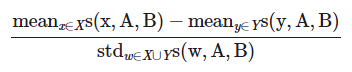   
- 두 벡터의 유사도를 측정하기 위해서 `cosine similarity(코사인 유사도)`를 이용한다.
- target에 있는 단어가 두 attribute 셋에 속한 단어들과의 유사도의 평균(mean)값이 얼마나 차이 나는지 측정한다.
- 개별단어가 개념축(attribute_A, B)에 대해 가지는 편향성을 계산한 값이다.
- X, Y에 속하는 모든 단어들이 가지는 편향성의 값의 표준편차(std)로 normalize한 값이 최종 WEAT score가 된다.

우선 `cosine similarity(코사인 유사도)`를 구하는 함수를 정의해보자.

In [26]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

`WEAT score` 공식에서 '분자'에 해당하는 부분을 계산하는 함수를 정의해보자.

In [27]:
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B  #, c_a, c_b

`WEAT score` 전체를 구하는 함수를 정의해보자.

In [28]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

`genre_name`의 길이(21x21)만큼 0으로 채운 매트릭스 형태로 표현한 `matrix`를 만들어보자.  
(추후 구한 결과를 `matrix`라는 변수에 담을 예정이다.)

In [29]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
matrix

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0,

각 영화 장르 별로 구한 `WEAT score`의 값을 `matrix`에 각각 할당한다.

In [30]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("슝~")

슝~


2개의 장르의 WEAT score값을 확인해보자.  
(WEAT score가 0.8이상, -0.8이하인 경우만 해석해보자.)

In [31]:
for i in range(len(genre_name)-1):
    print('[ attribute_A =', genre_name[i], ']')
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])
    print('----------------')

[ attribute_A = SF ]
SF 가족 -0.54423445
SF 공연 -0.33214158
SF 공포(호러) -0.46932292
SF 기타 0.045704
SF 다큐멘터리 0.17817634
SF 드라마 -0.25933334
SF 멜로로맨스 -0.45204166
SF 뮤지컬 -0.016432185
SF 미스터리 -0.45685992
SF 범죄 -0.28967845
SF 사극 -0.24989544
SF 서부극(웨스턴) -0.515277
SF 성인물(에로) -0.33615968
SF 스릴러 -0.39133552
SF 애니메이션 0.05378826
SF 액션 -0.4080083
SF 어드벤처 -0.51821274
SF 전쟁 0.17973046
SF 코미디 -0.48066
SF 판타지 -0.39827645
----------------
[ attribute_A = 가족 ]
가족 공연 0.39854667
가족 공포(호러) 0.33647224
가족 기타 0.6948535
가족 다큐멘터리 0.6043205
가족 드라마 0.6757731
가족 멜로로맨스 -0.15903787
가족 뮤지컬 0.5357902
가족 미스터리 0.21746422
가족 범죄 0.33168602
가족 사극 0.59820473
가족 서부극(웨스턴) 0.23976457
가족 성인물(에로) 0.038658533
가족 스릴러 0.3254128
가족 애니메이션 0.68412143
가족 액션 0.32828793
가족 어드벤처 0.49950463
가족 전쟁 0.50942326
가족 코미디 0.377746
가족 판타지 0.5572687
----------------
[ attribute_A = 공연 ]
공연 공포(호러) -0.076820254
공연 기타 0.54300207
공연 다큐멘터리 0.52925426
공연 드라마 0.05275832
공연 멜로로맨스 -0.33279005
공연 뮤지컬 0.58856314
공연 미스터리 -0.11012136
공연 범죄 0.04698212
공연 사극 0.42772767


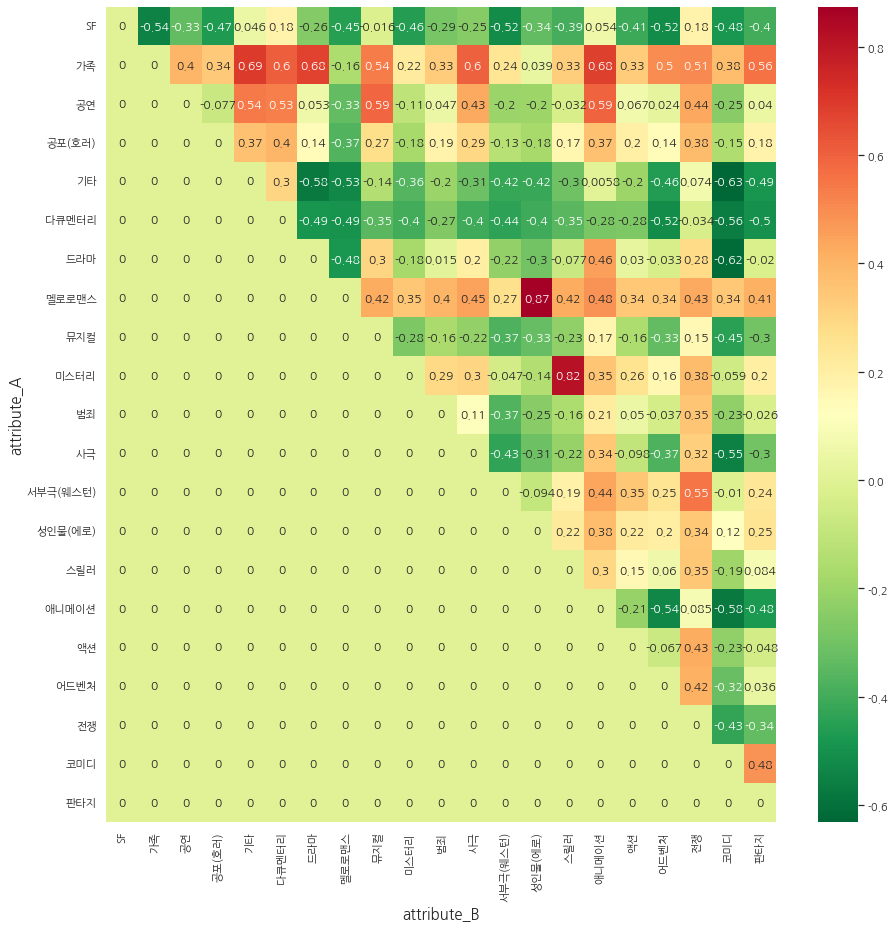

In [32]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = (15,15)

sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')

plt.ylabel('attribute_A', fontsize = 15)
plt.xlabel('attribute_B', fontsize = 15)

plt.show()

# 😎 결과
---

## 수치에 대한 결과
### `WEAT score`가 0.8이상인 것들만 따로 정리해보았다.
멜로로맨스 성인물(에로) 0.8739888
미스터리 스릴러 0.8183262
    
    
▶▶ `WEAT score`가 0.8 이상인 것이 2개 밖에 나오지 않았다.